# Loading the dataset

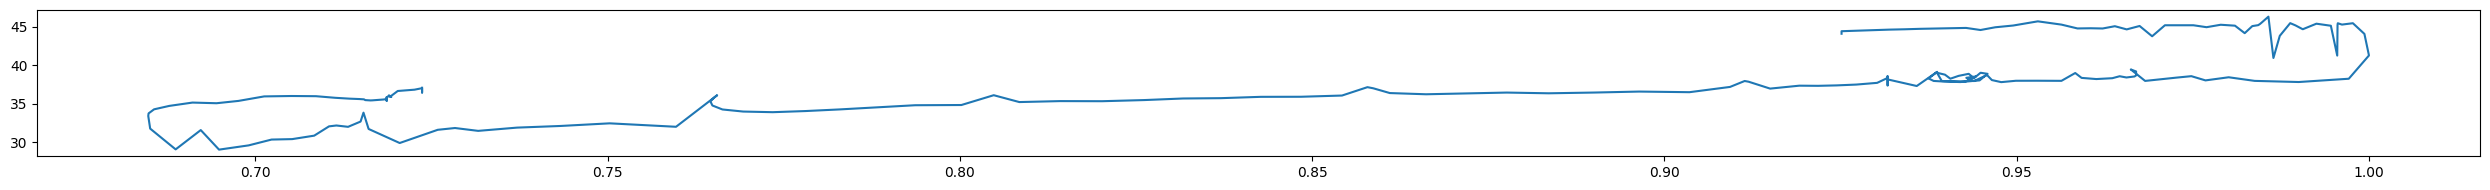

<Figure size 2500x200 with 0 Axes>

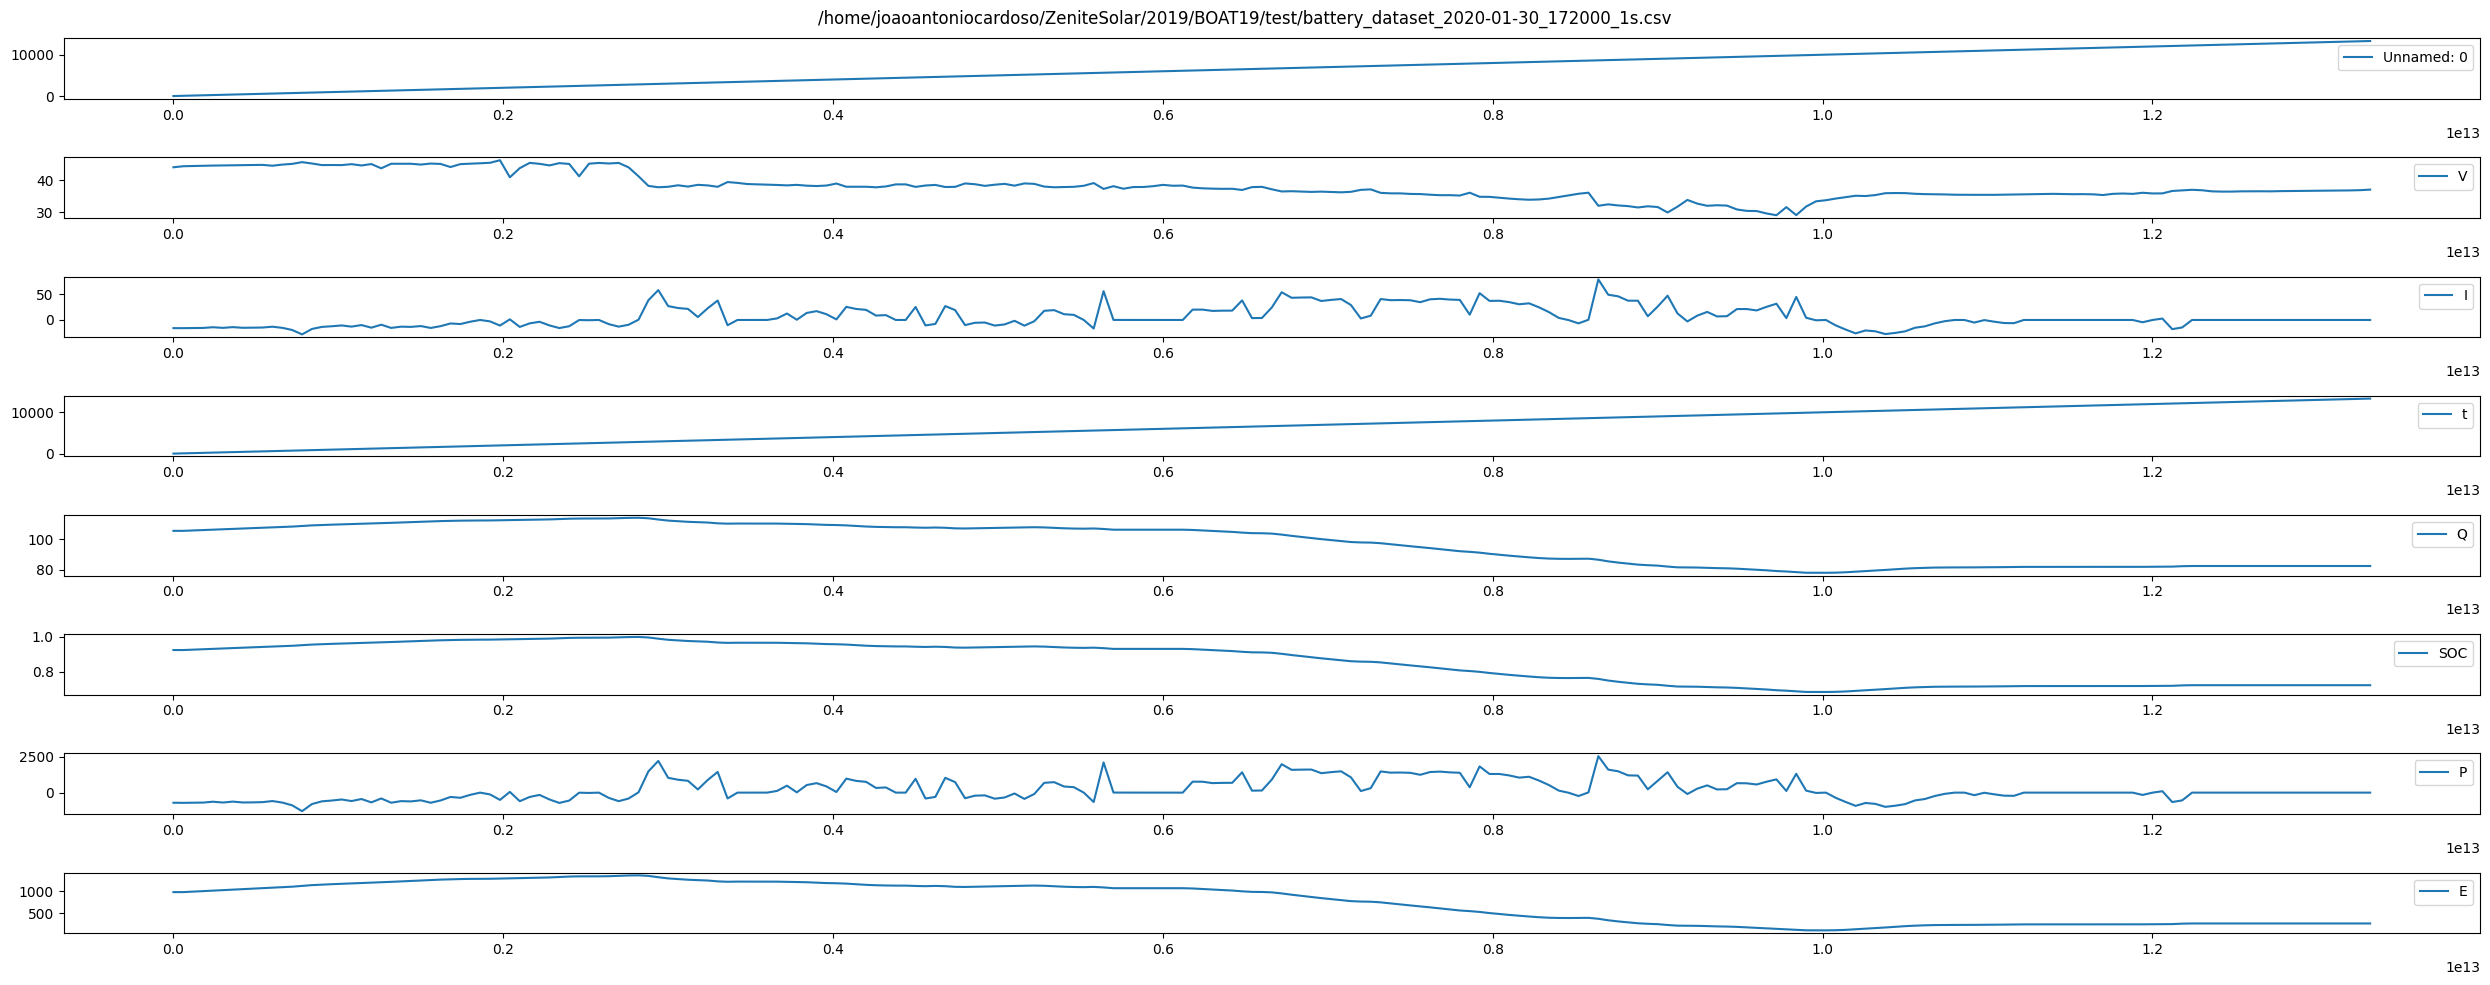

,Unnamed: 0,V,I,t,Q,SOC,P,E
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,6689.434978,37.958480,6.072541,6660.000000,97.140036,0.852106,188.259746,758.339797
std,3871.011618,4.095043,19.780656,3871.123868,12.924369,0.113372,721.416805,445.223786
min,29.500000,29.015624,-28.269492,0.000000,78.065418,0.684784,-1291.815140,109.170444
25%,3359.500000,35.626697,-7.853833,3330.000000,82.496291,0.723652,-319.940383,266.975449
50%,6689.500000,37.136850,0.000000,6660.000000,103.661176,0.909309,0.000000,978.586169
75%,10019.500000,38.841962,18.500711,9990.000000,108.636233,0.952949,671.597913,1147.290724
max,13335.000000,46.306309,79.444659,13320.000000,114.000000,1.000000,2541.154385,1368.000000


nans:  0


,Unnamed: 0,V,I,t,Q,SOC,P,E
Time,,,,,,,,
0 days 00:00:00,29.5,44.084269,-15.978034,0.0,105.465639,0.925137,-704.379960,984.340214
0 days 00:01:00,89.5,44.413586,-16.012333,60.0,105.465639,0.925137,-711.165119,984.340214
0 days 00:02:00,149.5,44.488303,-15.828339,120.0,105.730978,0.927465,-704.175929,996.134723
0 days 00:03:00,209.5,44.554942,-15.564214,180.0,105.992583,0.929759,-693.462648,1007.781711
0 days 00:04:00,269.5,44.619557,-14.194605,240.0,106.240573,0.931935,-633.356981,1018.838541
...,...,...,...,...,...,...,...,...
0 days 03:38:00,13109.5,36.716509,0.000000,13080.0,82.496291,0.723652,0.000000,266.975449
0 days 03:39:00,13169.5,36.769049,0.000000,13140.0,82.496291,0.723652,0.000000,266.975449
0 days 03:40:00,13229.5,36.817804,0.000000,13200.0,82.496291,0.723652,0.000000,266.975449


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import cumtrapz
import numpy as np

def compute_df_power(df, inplace=False):
    P = df['I'] * df['V']
    if inplace: df['P'] = P
    return P

def compute_df_energy(df, nominal_E, inplace=False):
    seconds_in_one_hour = 3600
    dE = cumtrapz(-df['P'], df['t']) / seconds_in_one_hour # units: Watt-hour
    dE = np.insert(dE, obj=1, values=dE[0])

    E = nominal_E + dE - dE.max()

    if inplace: df['E'] = E
    return E

def compute_df_soc(df, nominal_Q, inplace=False):
    SOC = df['Q'].to_numpy() / nominal_Q

    if inplace: df['SOC'] = SOC
    return SOC

def compute_df_capacity(df, inplace=False):
    seconds_in_one_hour = 3600.0
    dQ = cumtrapz(-df['I'], df['t']) / seconds_in_one_hour  # units: Amper-hour
    dQ = np.insert(dQ, obj=1, values=dQ[0])

    Q = nominal_Q + dQ - dQ.max()

    if inplace: df['Q'] = Q
    return Q


def load_df(filename, nominal_Q, initial_SOC, resample_rule='1s', rename_columns={}):
    df = pd.read_csv(filename)
    df = df.fillna(0.0)
    df = df.rename(columns=rename_columns)
    df = df[df['V'] > 10]

    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['Time'] = df['Time'] - df['Time'][0]

    df = df.set_index('Time', drop=True)

    # Resampling
    df = (df
        .resample(resample_rule)
        .mean()
        .interpolate(method='time', limit_area='inside')
    )

    # After resampling, create the equally-spaced 't' index, used for control simulations
    df['t'] = df.index.to_numpy(dtype='timedelta64[s]').astype(float)  # t is now a float in seconds

    compute_df_capacity(df, inplace=True)
    compute_df_soc(df, nominal_Q, inplace=True)
    compute_df_power(df, inplace=True)
    compute_df_energy(df, nominal_E, inplace=True)

    return df

filename = '/home/joaoantoniocardoso/ZeniteSolar/2019/BOAT19/test/battery_dataset_2020-01-30_172000_1s.csv'  # Interessante
# filename = '/home/joaoantoniocardoso/ZeniteSolar/2019/BOAT19/test/battery_dataset_2020-02-01_064222_1s.csv'  # Sprint
# filename = '/home/joaoantoniocardoso/ZeniteSolar/2019/BOAT19/test/battery_dataset_2020-02-01_064223_1s.csv'  # After sprint, mostly charging
rename_columns = {'t': 'Time'}

cell_amps_hour = 38
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = series_cells * parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 0.9
nominal_E = series_cells * parallel_cells * cell_amps_hour * cell_voltage

df = load_df(filename, resample_rule='1min', rename_columns=rename_columns, nominal_Q=nominal_Q, initial_SOC=initial_SOC)

plt.figure(figsize=(25, 2))
plt.plot(df['SOC'], df['V'])
plt.tight_layout()
plt.show()

plt.figure(figsize=(25, 2))

fig, ax = plt.subplots(len(df.columns), figsize=(25,10))
for k, col in enumerate(df.columns):
    ax[k].plot(df.index, df[col], label=col)
    ax[k].legend(loc=1)

plt.suptitle(filename)
plt.tight_layout()
plt.show()

display(df.describe())

# Check for nans in the data
print('nans: ', df.isna().sum().sum())

df

# Model

In [39]:
import control as ct

# ref: https://books.google.com.br/books?id=suLRCgAAQBAJ&pg=PA29&hl=pt-BR&source=gbs_toc_r&cad=2#v=onepage&q&f=false

class Battery:
    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Get the parameter values
        R_1 = params["R_1"]
        C_1 = params["C_1"]
        dt = params["dt"]  # units: Seconds
        Q = params["Q"]  # units: Ampere-seconds
        eta = params["eta"]

        # Get the inputs
        I = u[0]  # units: Ampere

        # Get the states from [k-1]
        SOC = x[0]
        I_R_1 = x[1]

        # Compute the state SOC[k]
        SOC = SOC - I * (dt * eta / Q)
        # SOC = np.clip(SOC, 0, 1)

        # Compute I_R_1[k]
        a = np.exp(- dt / (R_1 * C_1))
        I_R_1 = a * I_R_1 + (1 - a) * I

        return (SOC, I_R_1)

    @classmethod
    def _output(cls, t, x, u, params: dict):
        # Get the parameter values
        R_0 = params["R_0"]
        R_1 = params["R_1"]
        coeffs = params["coeffs"]

        # Get the inputs
        I = u[0]  # units: Ampere

        # Get the states from [k-1]
        SOC = x[0]
        I_R_1 = x[1]

        # Compute the OCV(SOC[k])
        OCV = np.polynomial.Polynomial(coeffs)(SOC)

        # Compute the output V[k]
        V = OCV - I * R_0 - R_1 * I_R_1

        return (V, SOC, OCV)

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._output,
            dt=params['dt'],
            name="battery",
            states=("SOC", "I_R_1",),
            inputs=("I",),
            outputs=("V", "SOC", "OCV"),
            params=params,
        )

# Optimization

differential_evolution step 1: f(x)= 1.00305e+18
differential_evolution step 2: f(x)= 1.00305e+18
differential_evolution step 3: f(x)= 6.43272e+17
differential_evolution step 4: f(x)= 1.33392e+17
differential_evolution step 5: f(x)= 1.33392e+17
differential_evolution step 6: f(x)= 1.02652e+16
differential_evolution step 7: f(x)= 3.30247e+15
differential_evolution step 8: f(x)= 1.78938e+15
differential_evolution step 9: f(x)= 1.78938e+15
differential_evolution step 10: f(x)= 1.37311e+14
differential_evolution step 11: f(x)= 8.46672e+12
differential_evolution step 12: f(x)= 8.46672e+12
differential_evolution step 13: f(x)= 8.46672e+12
differential_evolution step 14: f(x)= 5.21629e+12
differential_evolution step 15: f(x)= 5.21629e+12
differential_evolution step 16: f(x)= 5.21629e+12
differential_evolution step 17: f(x)= 5.21629e+12
differential_evolution step 18: f(x)= 5.53699e+11
differential_evolution step 19: f(x)= 5.53699e+11
differential_evolution step 20: f(x)= 5.53699e+11
different

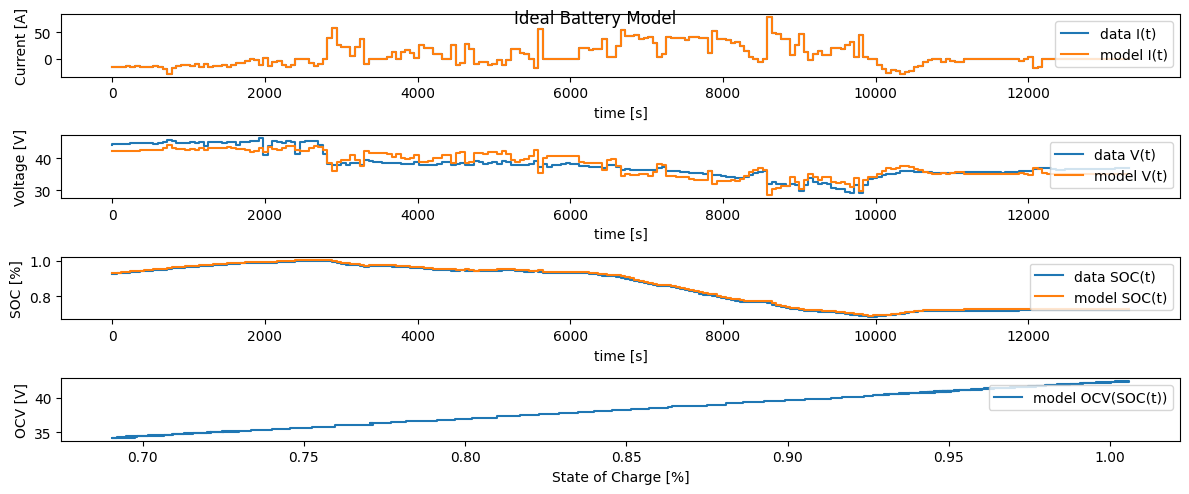

In [41]:
import lmfit

def simulate(params, data):
    # Convert lmfit parameters into the model parameters
    battery_system = Battery.build(params)

    T = data['t']
    U = data['I']
    a = np.exp(- params['dt'] / (params['R_1'] * params['C_1']))
    X0 = [
        data['SOC'].iloc[0] - data['I'].iloc[0] * (params['dt'] * params['eta'] / params['Q']),
        (1 - a) * data['I'].iloc[0],
    ]

    # Simulate the system response
    return ct.input_output_response(
        battery_system, T=T, U=U, X0=X0, solve_ivp_kwargs={"method": "Radau"}
    ).to_pandas().set_index("time")

def residuals(params, data):
    # ref: https://hernandis.me/2020/04/05/three-examples-of-nonlinear-least-squares-fitting-in-python-with-scipy.html

    # Build the battery model with the current parameters
    n_coeffs = sum(1 for k in params.valuesdict().keys() if k.startswith('coeff_'))
    params = {
        'eta': params['eta'].value,
        'dt': params['dt'].value,
        'Q': params['Q'].value,
        'R_0': params['R_0'].value,
        'R_1': params['R_1'].value,
        'C_1': params['C_1'].value,
        'coeffs': [params[f'coeff_{i}'].value for i in range(n_coeffs - 1)],
    }

    res = simulate(params, data)

    # Calculate residuals
    return np.array([
        (res['V'].to_numpy() - data['V'].to_numpy()),
        (res['SOC'].to_numpy() - data['SOC'].to_numpy()),
    ]).flatten()

# Initial parameters
initial_eta = 1
initial_R_0 = 0.04
initial_R_1 = 0.01
initial_C_1 = 10
initial_coeffs = np.array([15.8899252, 26.4508463, 0, 0])
# initial_coeffs = np.zeros(4)

# Create lmfit Parameters object and set initial guesses
params = lmfit.Parameters()
params.add('eta', value=initial_eta, min=0.0, max=1, vary=False)
params.add('dt', value=df['t'].iloc[1] - df['t'].iloc[0], vary=False)
params.add('Q', value=nominal_Q * 3600, vary=False)  # Ampere-seconds
params.add('R_0', value=initial_R_0, min=0, max=1, vary=True)
params.add('R_1', value=initial_R_1, min=1e-6, max=10, vary=True)
params.add('C_1', value=initial_C_1, min=1e-9, max=1e9, vary=True)
# params.add('coeff_0', value=0, min=-1e9, max=1e9, vary=False)
for i in range(0, len(initial_coeffs)):
    params.add(f'coeff_{i}', value=initial_coeffs[i], min=-1e6, max=1e9, vary=True)

## Define data to fit
data = {
    't': (df['t'] - df['t'].iloc[0]).to_numpy(),  # simulation time in seconds
    'I': df['I'],
    'V': df['V'],
    'SOC': df['SOC'],
}

## Perform the fit
result = lmfit.minimize(
    residuals, params, args=(data,),
    # method='leastsq', # Levenberg-Marquardt (default)
    # method='least_squares', # Least-Squares minimization, using Trust Region Reflective method
    # method='differential_evolution', #
    # method='brute', # brute force method
    # method='basinhopping', # basinhopping
    # method='ampgo', # Adaptive Memory Programming for Global Optimization
    # method='nelder', # Nelder-Mead
    # method='lbfgsb', # L-BFGS-B
    # method='powell', # Powell
    # method='cg', # Conjugate-Gradient
    # method='cobyla', # Cobyla
    # method='bfgs', # BFGS
    # method='tnc', # Truncated Newton
    # method='trus', #ncg: Newton-CG trust-region
    # method='trus', #exact: nearly exact trust-region
    # method='trus', #krylov: Newton GLTR trust-region
    # method='trus', #constr: trust-region for constrained optimization
    # method='dogleg', # Dog-leg trust-region
    # method='slsqp', # Sequential Linear Squares Programming
    # method='emcee', # Maximum likelihood via Monte-Carlo Markov Chain
    # method='shgo', # Simplicial Homology Global Optimization
    # method='dual_annealing', # Dual Annealing optimization
    method="differential_evolution",  # differential evolution
    **dict( # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html
        updating="deferred",
        disp=True,
        polish=True,
        workers=6,
        max_nfev=6*100_000,
        seed=1,
        # strategy="currenttobest1bin",
        strategy="randtobest1bin",
    ),
)

fitted_params = result.params.valuesdict()

## Evaluate
params = {
    'eta': fitted_params['eta'],
    'dt': fitted_params['dt'],
    'Q': fitted_params['Q'],
    'R_0': fitted_params['R_0'],
    'R_1': params['R_1'],
    'C_1': params['C_1'],
    'coeffs': [params[f'coeff_{i}'].value for i in range(len(initial_coeffs) - 1)],
}

df_out = simulate(params, data)

## Plot
if True:
    fig, ax = plt.subplots(4, figsize=(12, 5))
    ax[0].step(df['t'], df["I"], label="data I(t)")
    ax[0].step(df['t'], df_out["I"], label="model I(t)")
    ax[0].set_xlabel("time [s]")
    ax[0].set_ylabel("Current [A]")
    ax[0].legend(loc=1)

    ax[1].step(df['t'], df["V"], label="data V(t)")
    ax[1].step(df['t'], df_out["V"], label="model V(t)")
    ax[1].set_xlabel("time [s]")
    ax[1].set_ylabel("Voltage [V]")
    ax[1].legend(loc=1)

    ax[2].step(df['t'], df["SOC"], label="data SOC(t)")
    ax[2].step(df['t'], df_out["SOC"], label="model SOC(t)")
    ax[2].set_xlabel("time [s]")
    ax[2].set_ylabel("SOC [%]")
    ax[2].legend(loc=1)

    ax[3].step(df_out["SOC"], df_out["OCV"], label="model OCV(SOC(t))")
    ax[3].set_xlabel("State of Charge [%]")
    ax[3].set_ylabel("OCV [V]")
    ax[3].legend(loc=1)

    plt.tight_layout()
    plt.suptitle("Ideal Battery Model")
    plt.show()

## Print the optimization report
display(result)